In [1]:
import os

# -- Locate Java installation --

#def is_java_9():
#
#def try_set_java_9():
#    subprocess.check_output(['/usr/libexec/java_home', '-v', '9']).split('\n')
#
# TODO: Require Java 9?

def setenv(k, v):
    os.environ[k] = v
    print(k + ' -> ' + v)

conda_env = os.getenv('CONDA_PREFIX')
print('Conda environment: ' + conda_env)

# FIXME - generalize
# NB: In my tests, Java 8 (both 121 and 152) segfaulted, whereas Java 9
# worked. But I had to `sudo ln -s . jre` in my Java installation to make
# pyjnius find libjvm.dylib where it expected to find it. This is because
# Java 9 no longer nests the JRE inside a subfolder called jre.
setenv('JAVA_HOME', '/home/loci/Applications/jdk-9.0.4')

# -- Locate the pyjnius Java library --

if os.getenv('PYJNIUS_JAR') is None:
    pyjnius_dir = conda_env + '/share/pyjnius/'
    setenv('PYJNIUS_JAR', pyjnius_dir + os.listdir(pyjnius_dir)[0])
else:
    print('PYJNIUS_JAR already set: ' + os.getenv('PYJNIUS_JAR'))

# -- Set up the Java classpath --

# ImageJ
ij_dir = '/home/loci/code/Fiji.app' # FIXME
jars = []
for root, dirs, files in os.walk(ij_dir + '/jars'):
    for file in files:
        if file.endswith('.jar') and \
                not file.startswith('imagej-legacy-') and \
                not file.startswith('ij1-patcher-') and \
                not file.startswith('ij-1.'):
            jars.append(root + '/' + file)
classpath = ":".join(jars)

# ImgLyb
imglyb_dir = conda_env + '/share/imglyb/'
imglyb_jar = imglyb_dir + os.listdir(imglyb_dir)[0]
classpath += ':' + imglyb_jar

os.environ['IMGLYB_JAR'] = classpath
print("Added " + str(len(jars) + 1) + " JARs to the Java classpath.")

Conda environment: /home/loci/anaconda3/envs/cp-notebooks
JAVA_HOME -> /home/loci/Applications/jdk-9.0.4
PYJNIUS_JAR already set: /home/loci/anaconda3/envs/cp-notebooks/share/pyjnius/pyjnius.jar
Added 261 JARs to the Java classpath.


In [2]:
import json
import os
import StringIO

import cellprofiler.image
import cellprofiler.measurement
import cellprofiler.object
import cellprofiler.pipeline
import cellprofiler.preferences
import cellprofiler.workspace
import imglyb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import jnius
from jnius import JavaException
import skimage.io

/home/loci/anaconda3/envs/cp-notebooks/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using python < 3. Upgrade to python 3 recommended


In [3]:
def run_pipeline(pipeline_filename, image_dict):
    cellprofiler.preferences.set_headless()
    
    # Create and load the pipeline
    pipeline = cellprofiler.pipeline.Pipeline()
    pipeline.load(pipeline_filename)
    
    # Create the image set, and add the image data
    image_set_list = cellprofiler.image.ImageSetList()
    image_set = image_set_list.get_image_set(0)
    for image_name, input_pixels in image_dict.iteritems():
        image_set.add(image_name, cellprofiler.image.Image(input_pixels))
        
    # Persist the object set here (for now, see workspace TODO)
    object_set = cellprofiler.object.ObjectSet()

    # We can only run one group -- set the group index to 1.
    measurements = cellprofiler.measurement.Measurements()
    measurements.group_index = 1

    # Run the modules!
    for module in pipeline.modules():
        # Yes, we really do have to create a new workspace for each module
        # because the module attribute is required. Go team.
        workspace = cellprofiler.workspace.Workspace(
            image_set=image_set,
            image_set_list=image_set_list,
            measurements=measurements, 
            module=module,
            object_set=object_set, 
            pipeline=pipeline
        )
        
        module.prepare_run(workspace)
        module.run(workspace)
        module.post_run(workspace)
    
    # The workspace object has access to the measurements
    # and the image set/image set list which can be used
    # to use/view/store/whatever output data.
    return workspace


def objects2df(measurements, objects_name):
    features = measurements.get_feature_names(objects_name)
    
    n_features = len(features)
    n_objects = int(measurements.get_measurement("Image", "Count_{}".format(objects_name)))
    
    data = np.empty((n_objects, n_features))
    
    for feature_idx, feature in enumerate(features):
        data[:, feature_idx] = measurements.get_measurement(objects_name, feature)
    
    return pd.DataFrame(
        data=data,
        index=np.arange(1, n_objects + 1),
        columns=features
    )


def data2image(data):
    return Image.open(StringIO.StringIO(data))


def show(image):
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

In [4]:
# Spin up the ImageJ context.
ImageJ = jnius.autoclass('net.imagej.ImageJ')
ij = ImageJ()

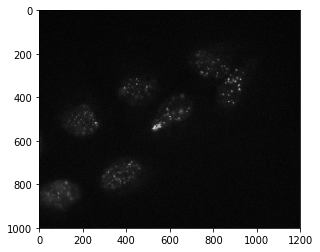

In [5]:
img = skimage.io.imread('data/images/1-162hrh2ax2.tif')
show(img)

In [6]:
HashMap = jnius.autoclass('java.util.HashMap')
input_map = HashMap()
result = ij.command().run("org.scijava.plugins.commands.debug.SystemInformation", True, input_map).get()

#result.getOutputs().toString()    #### AttributeError: 'java.util.Map' object has no attribute 'toString'
# pyjnius is being too strict -- you write foo.toString()
# and it fails because toString is not a Map method (or superinterface of Map method)
# Java compiler knows all objects extend Object, so you can say foo.toString()
# I would call this a bug in pyjnius.

Objects = jnius.autoclass('java.util.Objects')
print('info is ' + str(len(Objects.toString(result.getOutputs()))) + ' characters long.')

info = result.getOutputs().get('info')
# does pyjnius have code to go from [] <-> List and {} <-> Map
# if not: we should write these functions
# https://github.com/kivy/pyjnius/issues/217

info is 361280 characters long.


In [ ]:
# Invoke the FindEdges command of ImageJ.
#image_display = ij.display().createDisplay(imglyb.to_imglib(img))

In [7]:
print(ij.op().help("create.img"))

Available operations:
	(Img out) =
	net.imagej.ops.create.img.CreateImgFromImg(
		Img in)
	(Img out) =
	net.imagej.ops.create.img.CreateImgFromII(
		IterableInterval in)
	(Img out) =
	net.imagej.ops.create.img.CreateImgFromRAI(
		RandomAccessibleInterval in)
	(Img out) =
	net.imagej.ops.create.img.CreateImgFromDimsAndType(
		Dimensions in1,
		NativeType in2,
		ImgFactory factory?)
	(Img out) =
	net.imagej.ops.create.img.CreateImgFromInterval(
		Interval in)


In [17]:
HashMap = jnius.autoclass('java.util.HashMap')
input_map = HashMap()
print( imglyb.to_imglib(img))
img_copy = ij.op().run("create.img", imglyb.to_imglib(img))
input_map.put('display', ij.display().createDisplay(img_copy))

#class_name = 'net.imagej.plugins.commands.neigh.FindEdges'
#result = ij.command().run(class_name, True, input_map).get()
#Objects.toString(result.getOutputs())

<net/imglib2/python/ReferenceGuardingRandomAccessibleInterval at 0x7f15edbd7cb0 jclass=net/imglib2/python/ReferenceGuardingRandomAccessibleInterval jself=<LocalRef obj=0x7f1674004a80 at 0x7f16045a64b0>>


In [44]:
class_name = 'net.imagej.plugins.commands.neigh.FindEdges'
output = ij.command().run(class_name, True, input_map).get()
print(output.getOutputs().get('display'))
Objects.toString(output.getOutputs())

<net.imagej.display.DefaultImageDisplay at 0x7f15edbaaad0 jclass=net/imagej/display/DefaultImageDisplay jself=<LocalRef obj=0x55738536a2c0 at 0x7f16045a68b0>>


'{display=null}'

In [52]:
# how to get image from default Image display?
service = jnius.autoclass('net.imagej.display.ImageDisplayService')
display = output.getOutputs().get("display")
service.getActiveDataset(display)
print(display)

JavaException: No methods matching your arguments

In [25]:
#how to convert?
print(output.getOutputs().get("display"))

<net.imagej.display.DefaultImageDisplay at 0x7f15f2aadd70 jclass=net/imagej/display/DefaultImageDisplay jself=<LocalRef obj=0x557384d84ce8 at 0x7f16045a6530>>


In [ ]:
images = {
    'EnhancedGreen': enhanced,
    'OrigBlue': skimage.io.imread('data/images/1-162hrhoe2.tif'),
    'OrigGreen': img
}

pipeline_filename = 'data/ExampleSpeckles.cppipe'

workspace = run_pipeline(pipeline_filename, images)

In [ ]:
df = objects2df(workspace.measurements, "Nuclei")
df.head()

In [ ]:
nuclei = workspace.object_set.get_objects("Nuclei")
skimage.io.imshow(nuclei.segmented)